Import packages

In [5]:
import pyodbc
import pandas as pd
import matplotlib.pyplot as plt


Connect to server

In [6]:
# connecting to SQL server (requires VPN connection)
conn = pyodbc.connect('Driver={SQL Server};'
                      'Server=BALT-AGLISTENER;'
                      'Database=COB_Cityworks;'
                      'Trusted_Connection=yes;')

#SQL Query
SQL_Query = pd.read_sql_query('''SELECT * FROM azteca.WORKORDER
WHERE APPLYTOENTITY = 'WA_METER'
AND INITIATEDATE  BETWEEN '2017-01-01' AND '2020-12-31'
AND DESCRIPTION <> 'WATER METER VAULTS'
AND TILENO = 'Baltimore City'
''',conn)

Create dataframe

In [7]:
df = pd.DataFrame(SQL_Query, columns=['WORKORDERID','DESCRIPTION', 'TILENO', 'WOADDRESS','PROJSTARTDATE','PROJFINISHDATE','ACTUALSTARTDATE',
             'WOXCOORDINATE','WOYCOORDINATE'])


#When the workorder was actually finished
df['F_Date'] =  pd.to_datetime(SQL_Query['ACTUALFINISHDATE'], errors='coerce')
df['F_Year'] = df['F_Date'].dt.year
df_mask=df['F_Year']>=2017.0
df = df[df_mask]

#Year WO was initiated (Possibly use instead of start)
df['I_Date'] =  pd.to_datetime(SQL_Query['INITIATEDATE'], errors='coerce')
#df['I_Year'] = df['I_Date'].dt.year

#Year WO was actually started
#df['S_Date'] =  pd.to_datetime(df['ACTUALSTARTDATE'], errors='coerce')
#df['S_Year'] = df['S_Date'].dt.year

#Age of work order in days
day_age = (df['F_Date'] - df['I_Date'])#.astype('timedelta64[D]')
df['Age'] = day_age


#df.head()

Set up dataframe for age of work order per month by year

In [8]:
df1 = pd.DataFrame(df, columns = ["age", "date"])
finished_month_year = pd.to_datetime(df['F_Date'], errors='coerce').dt.to_period('M')
df1['date'] = finished_month_year
df1["age"] = (df['F_Date']-df['I_Date']).dt.days

grouped_df = df1.groupby('date')['age'].mean()
grouped_df = pd.DataFrame(grouped_df)
grouped_df['month'] = grouped_df.index.strftime("%B")

graph_17 = grouped_df.loc['2017-01':'2017-12']
graph_18 = grouped_df.loc['2018-01':'2018-12']
graph_19 = grouped_df.loc['2019-01':'2019-12']
graph_20 = grouped_df.loc['2020-01':'2020-12']
#graph_21 = grouped_df.loc['2021-01':'2021-12']


Export monthly age of work orders dataframe to as csv

In [9]:
#grouped_df.to_csv(index=False)

Set x and y values for monthly age of work orders chart

In [10]:
x = graph_17['month']
y17 = graph_17.age
y18 = graph_18.age
y19 = graph_19.age
y20 = graph_20.age

Plot the average age of work order by year and then month

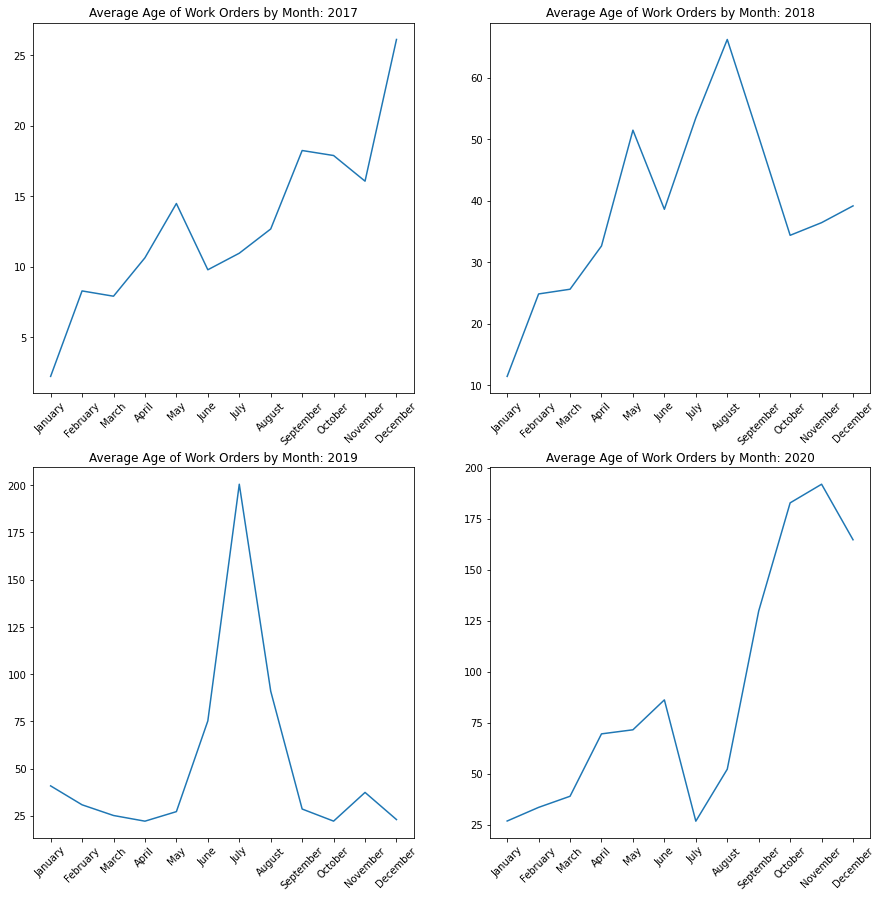

In [11]:
figure, axis = plt.subplots(2, 2, figsize=(15,15))

axis[0, 0].plot(x,y17)
axis[0, 0].set_title("Average Age of Work Orders by Month: 2017")
axis[0, 0].tick_params('x',labelrotation=45)
#axis[0, 0].annotate('figure pixels',xy=(10, 10), xycoords='figure pixels')


axis[0, 1].plot(x,y18)
axis[0, 1].set_title("Average Age of Work Orders by Month: 2018")
axis[0, 1].tick_params('x', labelrotation=45)

axis[1, 0].plot(x,y19)
axis[1, 0].set_title("Average Age of Work Orders by Month: 2019")
axis[1, 0].tick_params('x', labelrotation=45)

axis[1, 1].plot(x,y20)
axis[1, 1].set_title("Average Age of Work Orders by Month: 2020")
axis[1, 1].tick_params('x', labelrotation=45)


# Rolling Day Average

Dataframe: Rolling average of work order age 

In [12]:
df_rolling = pd.DataFrame(df, columns = ["age", "date"],dtype = float)
finished_day_month_year = pd.to_datetime(df['F_Date'], errors='coerce').dt.to_period('D')
df_rolling['date'] = finished_day_month_year
df_rolling["age"] = (df['F_Date']-df['I_Date']).dt.days

rolling_grouped_df = df_rolling.groupby('date')['age'].mean()
rolling_grouped_df = pd.DataFrame(rolling_grouped_df)

Calculate rolling day avg

Text(0, 0.5, 'Age (Days)')

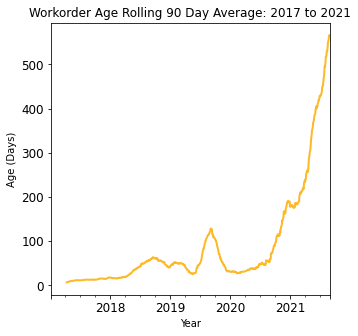

In [13]:
rolling_day_avg = rolling_grouped_df.rolling(90, min_periods= 90).mean()
rolling_day_avg= pd.DataFrame(rolling_day_avg)
rolling_day_avg['month'] = rolling_day_avg.index.strftime("%B")

#2017 to 2020 Rolling 90 Average
rolling_day_avg.plot(title = "Workorder Age Rolling 90 Day Average: 2017 to 2021", figsize = (5,5), 
fontsize = 12, linewidth = 2, color = "#FDB927", legend = False)
plt.xlabel("Year")
plt.ylabel("Age (Days)")
#rolling_day_avg

Dataframe to csv file

In [14]:
#rolling_day_avg.to_csv(index = False)

Parse data by year, add columns for age, and month the work order was finished/closed

In [62]:
roll_graph_17 = rolling_day_avg.loc['2017-1':'2017-12']
roll_graph_18 = rolling_day_avg.loc['2018-01':'2018-12']
roll_graph_19 = rolling_day_avg.loc['2019-01':'2019-12']
roll_graph_20 = rolling_day_avg.loc['2020-01':'2020-12']

ry17 = roll_graph_17.age
ry18 = roll_graph_18.age 
ry19 = roll_graph_19.age
ry20 = roll_graph_20.age

rx17 = roll_graph_17.month
rx18 = roll_graph_18.month
rx19 = roll_graph_19.month
rx20 = roll_graph_20.month

Plots the rolling 90 day average, broken down by year

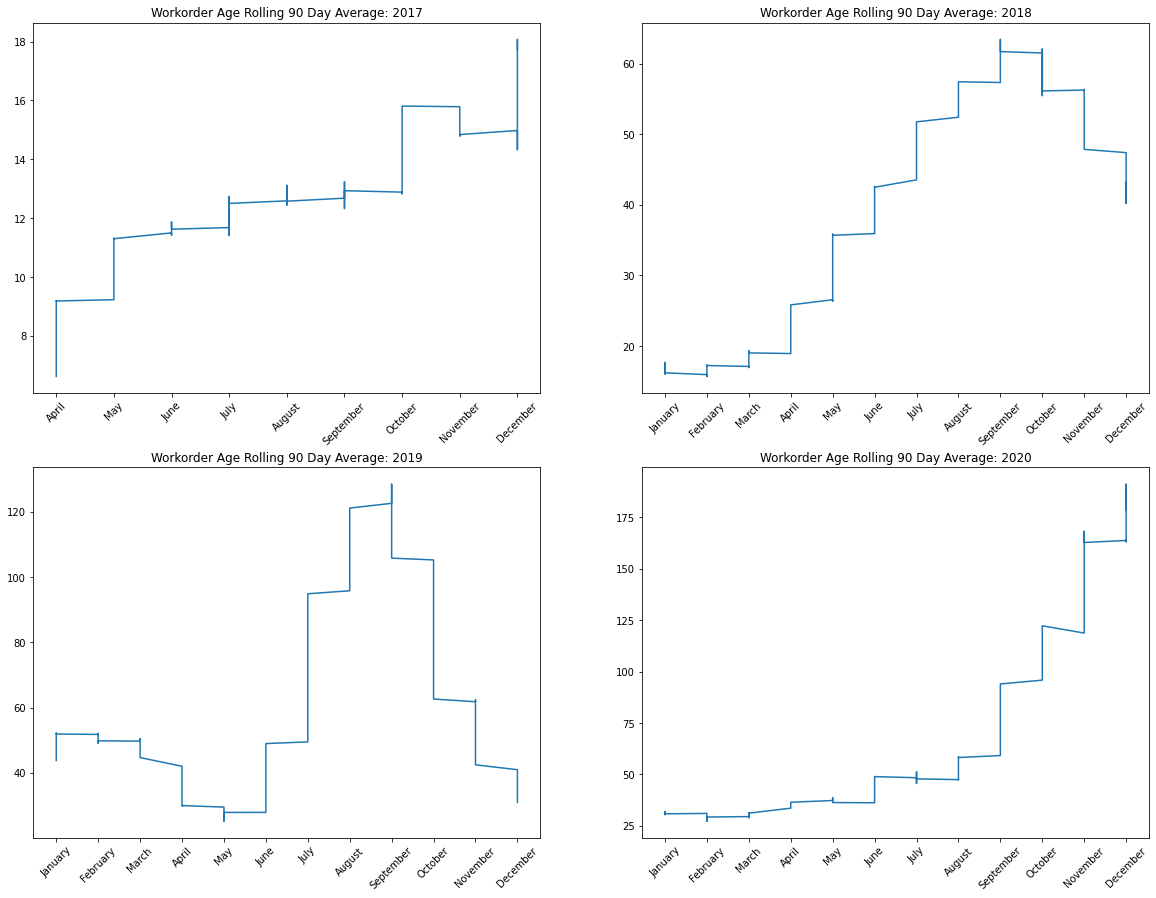

In [63]:
figure, axis = plt.subplots(2, 2, figsize=(20,15))

axis[0, 0].plot(rx17,ry17)
axis[0, 0].set_title("Workorder Age Rolling 90 Day Average: 2017")
axis[0, 0].tick_params('x',labelrotation=45)
#axis[0, 0].annotate('figure pixels',xy=(10, 10), xycoords='figure pixels')


axis[0, 1].plot(rx18,ry18)
axis[0, 1].set_title("Workorder Age Rolling 90 Day Average: 2018")
axis[0, 1].tick_params('x', labelrotation=45)

axis[1, 0].plot(rx19,ry19)
axis[1, 0].set_title("Workorder Age Rolling 90 Day Average: 2019")
axis[1, 0].tick_params('x', labelrotation=45)

axis[1, 1].plot(rx20,ry20)
axis[1, 1].set_title("Workorder Age Rolling 90 Day Average: 2020")
axis[1, 1].tick_params('x', labelrotation=45)

<AxesSubplot:title={'center':'Workorder Age Rolling 90 Day Average: 2020'}, xlabel='date'>

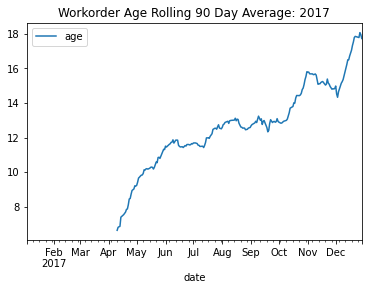

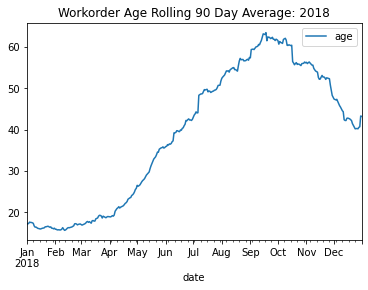

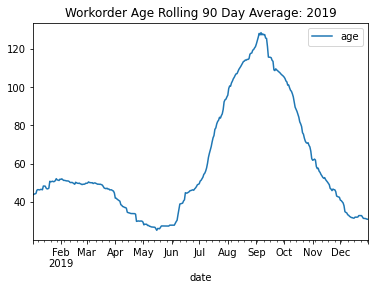

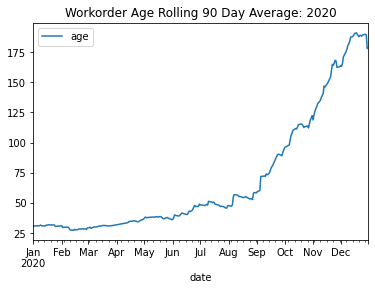

In [54]:
roll_graph_17.plot(title = "Workorder Age Rolling 90 Day Average: 2017")
 oll_graph_18.plot(title = "Workorder Age Rolling 90 Day Average: 2018")
rroll_graph_19.plot(title = "Workorder Age Rolling 90 Day Average: 2019")
rroll_graph_20.plot(title = "Workorder Age Rolling 90 Day Average: 2020"))